# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

C:\Users\singh\AppData\Roaming\Python\Python311\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


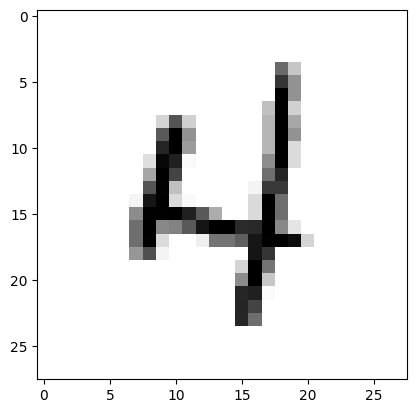

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

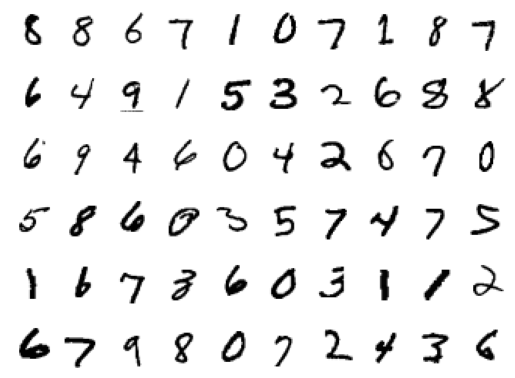

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [7]:
dropout_value = 0.08
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11            [-1, 8, 10, 10]             576
             ReLU-12            [-1, 8, 10, 10]               0
      BatchNorm2d-13

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.10423526912927628 Batch_id=468 Accuracy=87.15: 100%|██████████| 469/469 [00:20<00:00, 23.00it/s] 



Test set: Average loss: 0.1098, Accuracy: 9695/10000 (96.95%)

EPOCH: 1


Loss=0.04257380589842796 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:12<00:00, 37.57it/s] 



Test set: Average loss: 0.0645, Accuracy: 9800/10000 (98.00%)

EPOCH: 2


Loss=0.05573160946369171 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:12<00:00, 38.51it/s] 



Test set: Average loss: 0.0375, Accuracy: 9885/10000 (98.85%)

EPOCH: 3


Loss=0.1383875459432602 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:11<00:00, 40.65it/s]  



Test set: Average loss: 0.0358, Accuracy: 9894/10000 (98.94%)

EPOCH: 4


Loss=0.03684263303875923 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:11<00:00, 41.27it/s]  



Test set: Average loss: 0.0365, Accuracy: 9883/10000 (98.83%)

EPOCH: 5


Loss=0.027188392356038094 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:13<00:00, 34.66it/s]



Test set: Average loss: 0.0328, Accuracy: 9886/10000 (98.86%)

EPOCH: 6


Loss=0.052606821060180664 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:12<00:00, 37.51it/s]



Test set: Average loss: 0.0325, Accuracy: 9904/10000 (99.04%)

EPOCH: 7


Loss=0.05607281252741814 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:13<00:00, 33.81it/s] 



Test set: Average loss: 0.0333, Accuracy: 9897/10000 (98.97%)

EPOCH: 8


Loss=0.015031981281936169 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:12<00:00, 36.25it/s] 



Test set: Average loss: 0.0275, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.08115040510892868 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:14<00:00, 31.27it/s]  



Test set: Average loss: 0.0310, Accuracy: 9904/10000 (99.04%)

EPOCH: 10


Loss=0.007305916398763657 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 35.24it/s] 



Test set: Average loss: 0.0276, Accuracy: 9909/10000 (99.09%)

EPOCH: 11


Loss=0.016489168629050255 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:12<00:00, 37.65it/s] 



Test set: Average loss: 0.0275, Accuracy: 9919/10000 (99.19%)

EPOCH: 12


Loss=0.0038505380507558584 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:14<00:00, 32.85it/s]



Test set: Average loss: 0.0246, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.03403613343834877 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:12<00:00, 38.00it/s]   



Test set: Average loss: 0.0289, Accuracy: 9914/10000 (99.14%)

EPOCH: 14


Loss=0.05165889859199524 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:11<00:00, 41.11it/s]  



Test set: Average loss: 0.0241, Accuracy: 9926/10000 (99.26%)

EPOCH: 15


Loss=0.040911268442869186 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:11<00:00, 40.38it/s]  



Test set: Average loss: 0.0274, Accuracy: 9917/10000 (99.17%)

EPOCH: 16


Loss=0.007189655210822821 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:10<00:00, 42.66it/s] 



Test set: Average loss: 0.0250, Accuracy: 9927/10000 (99.27%)

EPOCH: 17


Loss=0.0845784917473793 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:10<00:00, 43.17it/s]    



Test set: Average loss: 0.0262, Accuracy: 9926/10000 (99.26%)

EPOCH: 18


Loss=0.09506108611822128 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:11<00:00, 40.10it/s]   



Test set: Average loss: 0.0262, Accuracy: 9928/10000 (99.28%)

EPOCH: 19


Loss=0.0027152318507432938 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:11<00:00, 41.56it/s] 



Test set: Average loss: 0.0264, Accuracy: 9926/10000 (99.26%)

EPOCH: 20


Loss=0.059215713292360306 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:10<00:00, 42.64it/s]  



Test set: Average loss: 0.0253, Accuracy: 9916/10000 (99.16%)

EPOCH: 21


Loss=0.07883626967668533 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:11<00:00, 40.67it/s]  



Test set: Average loss: 0.0233, Accuracy: 9936/10000 (99.36%)

EPOCH: 22


Loss=0.011509641073644161 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:11<00:00, 39.84it/s] 



Test set: Average loss: 0.0260, Accuracy: 9929/10000 (99.29%)

EPOCH: 23


Loss=0.013933665119111538 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:11<00:00, 40.88it/s] 



Test set: Average loss: 0.0229, Accuracy: 9925/10000 (99.25%)

EPOCH: 24


Loss=0.04482509195804596 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:10<00:00, 44.68it/s]   



Test set: Average loss: 0.0231, Accuracy: 9938/10000 (99.38%)



Text(0.5, 1.0, 'Test Accuracy')

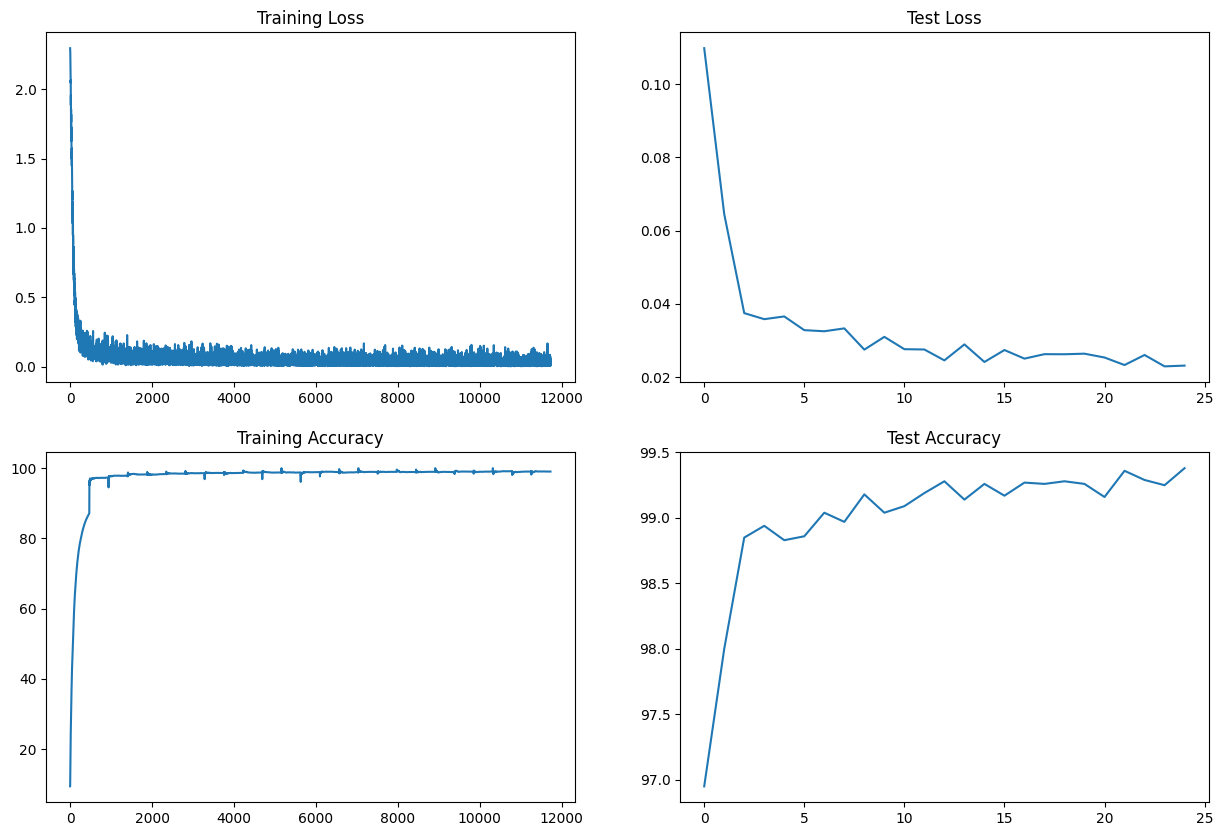

In [11]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")